In [1]:
import h5py
import numpy as np

files = ['ModelNet40_test/ply_data_test0.h5',
         'ModelNet40_test/ply_data_test1.h5']
#files = ['ModelNet10_test/modelnet10_test.h5']

d = []
l = []

for i in range(len(files)):
    fh5 = h5py.File(files[0], 'r')
    data = fh5['data'][:]
    label = fh5['label'][:]
    fh5.close()
    if(i != 0):
        d = np.append(d, data, axis=0)
        l = np.append(l, label, axis=0)
    else:
        d = data
        l = label
        
print d.shape
print l.shape

(4096, 2048, 3)
(4096, 1)


In [2]:
from keras.utils import to_categorical
Y_train = to_categorical(l)
classes = Y_train.shape[1]
print Y_train.shape
print "Loaded dataset with %s classes"%(classes)

Using TensorFlow backend.


(4096, 40)
Loaded dataset with 40 classes


In [3]:
X_train = np.asarray(d)
print X_train.shape

(4096, 2048, 3)


In [4]:
import numpy as np
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils

In [5]:
num_points = 2048

def mat_mul(A, B):
    return tf.matmul(A, B)

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)


# number of categories
k = classes

from keras import backend as K
# We want to ensure naming is consistent
K.clear_session()


input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

# point_net_cls
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(k, activation='softmax')(c)
prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

# print the model summary
model = Model(inputs=input_points, outputs=prediction)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
if(classes == 40):
    model.load_weights('PointNetVanilla-Complete.h5')
if(classes == 10):
    model.load_weights('PointNet-ModelNet10.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 3)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2048, 3)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 64)          256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048, 64)          256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2048, 64)          4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048, 64)          256       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2048, 64)          0         
__________

In [6]:
def pointNet_predict(x):
    to_pred = np.asarray([x])
    val = model.predict(to_pred)
    #print "Predicted class: %s with confidence: %s"%(val.argmax(), val.max())
    return val.max(), val.argmax()

pointNet_predict(X_train[4])

(0.6132974, 23)

In [7]:
test_subject = 1
def get_max_pool(test_subject):
    layer_name = 'max_pooling1d_3'
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    value_test = np.asarray([X_train[test_subject]])
    intermediate_output = intermediate_layer_model.predict(value_test)
    return intermediate_output

def get_latent_activations(test_subject):
    layer_name = 'batch_normalization_15'
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    value_test = np.asarray([X_train[test_subject]])
    intermediate_output = intermediate_layer_model.predict(value_test)
    return intermediate_output

    

In [8]:
def get_critical_set(test_subject):
    latent = get_latent_activations(test_subject)[0]
    critical_set = np.argmax(latent, axis=0)
    critical_set = set(critical_set)
    return critical_set

def get_cs(input_points):
    layer_name = 'batch_normalization_15'
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    value_test = np.asarray([input_points])
    latent = intermediate_layer_model.predict(value_test)[0]
    critical_set = np.argmax(latent, axis=0)
    critical_set = set(critical_set)
    #print "SIZE OF CS ", len(critical_set)
    return critical_set

cs = get_critical_set(20)
vecs = get_latent_activations(20)[0]
vals = get_max_pool(20)[0][0]
print vecs.shape
print vals.shape

print vecs[:,0].shape
print vals[0].shape
cs = []
for i in range(1024):
    cs.append(np.where(vecs[:,i] == vals[i])[0][0])
    
cs = set(cs)
print len(cs)

cs = get_critical_set(20)
print len(cs)

cs = get_cs(X_train[20])
print len(cs)

(2048, 1024)
(1024,)
(2048,)
()
555
555
555


In [9]:
distribution = []
from tqdm import trange
for i in trange(1000):
    cs = get_critical_set(i)
    distribution.append(len(cs))

100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


<IPython.core.display.Javascript object>


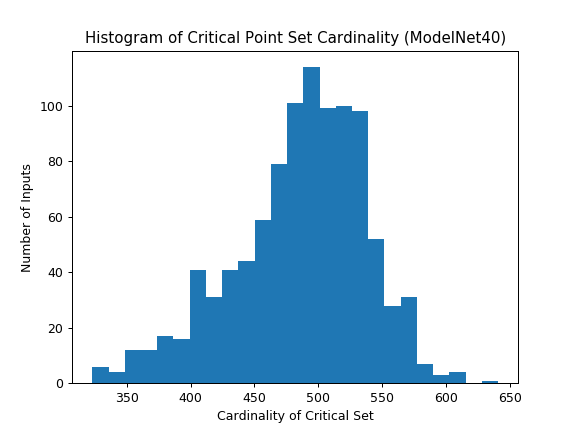

In [27]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure()
plt.title('Histogram of Critical Point Set Cardinality (ModelNet40)')
plt.ylabel('Number of Inputs')
plt.xlabel('Cardinality of Critical Set')
ax1 = fig1.add_subplot(111)
ax1.hist(distribution, 25)
plt.show()

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
"""
Here we just draw from the train set and then we 
display the points using matplotlib
"""
def load_and_view(n=0, vis_cs=True):
    x = X_train[n]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    X = x[:,0]
    Y = x[:,1]
    Z = x[:,2]
    
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())

    ax.scatter(X, Y, Z)
    
    if(vis_cs):
        cs = get_critical_set(test_subject)
        new_x = []
        for i in cs:
            new_x.append(x[i])
        new_x = np.asarray(new_x)
        Xcs = new_x[:,0]
        Ycs = new_x[:,1]
        Zcs = new_x[:,2]
        ax.scatter(Xcs, Ycs, Zcs, s=5, c='red')
            
    ax.scatter(Xb, Yb, Zb)
    
    plt.show()
    
    print "Done" 
    
model_num = 10
value = 0
for i in range(2000):
    if(np.argmax(Y_train[i]) == 7 and value == model_num):
        load_and_view(i)
        test_subject = i
        break
    elif(np.argmax(Y_train[i]) == 7 and value != model_num):
        value += 1

In [23]:
from tqdm import trange
import random
import sys

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.min(dist_2) #argmin will give us the index, right now we want the l2 distance

def max_dist_occlusion(example):
    confidences = [1]
    removed = []
    removed_ind = []
    points_occluded = 0
    x = list(X_train[example])
    y = np.argmax(Y_train[example])
    
    
    # First you have to calculate an all pairs distance
    # and keep a matrix of points with the smallest change
    nearest_neighbors = []
    for i in range(2048):
        replace = x[0]
        del x[0]
        nearest_neighbors.append(closest_node(replace, x))
        x.append(replace)
        
    conf, cl = pointNet_predict(x)
    if(cl != y):
        return 0,0,0,0
    
    # Calculate the critical set
    iterations = 0
    while(True):
        iterations += 1
        cs = get_cs(x)
        
        # Invert sort the critical set by the distance to the nearest neighbor
        cs = [c for _,c in sorted(zip(nearest_neighbors,cs))]
        cs = reversed(cs)
        
        # Manipulate and undo manipulations that increase the confidence 
        # of the network
        for i in cs:
            _replace = x[i]
            x[i] = [0,0,0] 
            conf, cl = pointNet_predict(x)
            sys.stdout.write("Points occluded: %s conf: %s \r"%(points_occluded, conf))
            sys.stdout.flush()
            if(cl != y):
                # lets refine the adversarial example:
                actually_removed = []
                actually_removed_ind = []
                for i in range(len(removed)):
                    x[removed_ind[i]] = removed[i]
                    conf, cl = pointNet_predict(x)
                    if(cl == y):
                        x[removed_ind[i]] = [0,0,0]
                        actually_removed.append(removed[i])
                        actually_removed_ind.append(removed_ind[i])
                        confidences.append(conf)
                        points_occluded -= 1
                    sys.stdout.write("Points occluded: %s conf: %s \r"%(points_occluded, conf))
                    sys.stdout.flush()
                print " "
                return len(actually_removed), x, actually_removed, actually_removed_ind                 
            if(cl != y):
                return len(removed), x, removed, removed_ind 
            if(conf >= confidences[-1] and iterations == 0):
                x[i] = _replace
                continue
            removed.append(_replace)
            removed_ind.append(i)
            points_occluded += 1
            confidences.append(conf)
        conf, cl = pointNet_predict(x)
    print "Misclassification via Occlusion is impossible"
    
num, adv, occ, _  = max_dist_occlusion(115)
print "Done"

 oints occluded: 1082 conf: 0.19225436 
Done


In [26]:
print len(occ)

50


In [13]:
def random_occlusion(example):
    x = list(X_train[example])
    y = np.argmax(Y_train[example])
    removed = []
    removed_ind = []
    
    confidences = []
    conf, cl = pointNet_predict(x)
    confidences.append(conf)
    if(cl != y):
        return 0,0,0,0
    
    points_occluded = 0
    occlude = np.random.permutation(2048)
    for i in occlude:
        removed.append(x[i])
        removed_ind.append(i)
        x[i] = [0,0,0]
        points_occluded += 1
        if(points_occluded % 5 == 0):
            conf, cl = pointNet_predict(x)
            #sys.stdout.write("Points occluded: %s conf: %s \r"%(points_occluded, conf))
            #sys.stdout.flush()
            if(cl != y):
                print " "
                return points_occluded, x, removed, removed_ind
            confidences.append(conf)
            
num2, adv2, occ, _ = random_occlusion(0)
print "Done"

 
Done


In [20]:
# Lets get the plot for lots of different examples
from tqdm import trange
start_index = 50
end_index = 150

errors = 0
opt_manip_dist = []
for i in range(start_index, end_index):
    #try:
    a,b,c,d = max_dist_occlusion(i)
    opt_manip_dist.append(a)
    print i, a
    #except:
    #errors += 1

rand_manip_dist = []
for i in trange(start_index, end_index):
    try:
        a,b,c,d = random_occlusion(i)
        rand_manip_dist.append(a)
        print i, a
    except:
        errors += 1


KeyboardInterrupt: 

In [15]:
print errors

195


In [16]:
import copy
rcpy = copy.deepcopy(rand_manip_dist)
ocpy = copy.deepcopy(opt_manip_dist)

In [17]:
pointNetReport = [[0,266],
                  [212,248],
                  [314,218],
                  [371,176],
                  [395,99]]
maxes = np.asarray([420,300]).astype('float')
pointNetReport = np.asarray(pointNetReport).astype('float')
pointNetReport /= maxes
pnx,pny = pointNetReport[:,0], pointNetReport[:,1]
print pnx,pny
print len(pnx), len(pny)

[0.         0.5047619  0.74761905 0.88333333 0.94047619] [0.88666667 0.82666667 0.72666667 0.58666667 0.33      ]
5 5


<IPython.core.display.Javascript object>


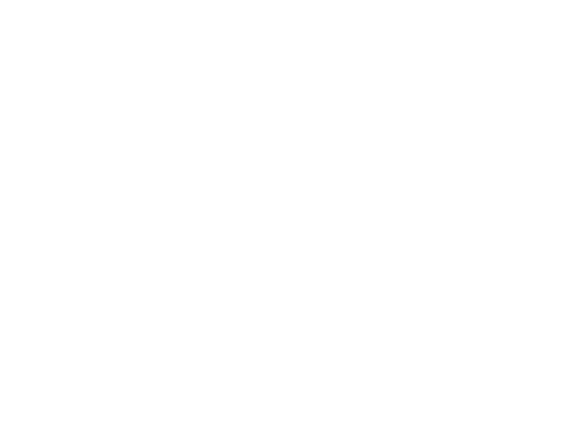

In [18]:
percent_correct_random = 1.00
percent_correct_optimized = 1.00

potr = [] # percent over time random
poto = []

srno = sorted(rand_manip_dist)
sono = sorted(opt_manip_dist)

samples = 100.0

for i in range(100):
    #print 2048.0*(i/100.0)
    #print 2048.0*(i+1/100.0)
    for x in srno:
        if(x <= 2048.0*(i/100.0) and x > 2048.0*((i-1)/100.0)):
            percent_correct_random -= 1.0/samples
            
    for x in sono:
        if(x <= 2048.0*(i/100.0) and x > 2048.0*((i-1)/100.0)):
            percent_correct_optimized -= 1.0/samples
            
    potr.append(percent_correct_random)
    poto.append(percent_correct_optimized)
    
fig1 = plt.figure()
plt.title('PointNet Robustness: ISO vs. Random (Occlusion) ModelNet10')
ax1 = fig1.add_subplot(111)

plt.plot(potr[0:], label="Random Occlusion", c='b')
plt.plot(poto[0:], label="ISO Occlusion", c='r')

#plt.scatter(pnx*100,pny, c='b',label='Report from Qi. et. al 2017')

plt.ylabel("Percent accuracy")
plt.xlabel("Percent of Missing Data")

params = {'legend.fontsize' : 8}
plt.rcParams.update(params)
plt.legend(loc=1, bbox_to_anchor=(0.4,0.18))
plt.show()
    

In [19]:
delta = np.asarray(potr[1:]) - np.asarray(poti[:-1]) 
delta2 = np.asarray(potr[1:]) - np.asarray(poto[1:]) 


fig1 = plt.figure()
plt.title('Overestimation of Model Robustness (Occlusion)')
ax1 = fig1.add_subplot(111)

plt.plot(delta, label="d = Random - Informed", c='m')
plt.plot(delta2, label="d2 = Random - Optimized", c='y')

plt.ylabel("Percent Overestimation")
plt.xlabel("Percent of Missing Data")

plt.legend()
plt.show()

NameError: name 'poti' is not defined

In [ ]:
"""
Here we just draw from the train set and then we 
display the points using matplotlib
"""
def load_and_view_obj(OBJ, c='b'):
    x = np.asarray(OBJ)
    print x.shape
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # superate x, y, and z
    X = x[:,0]
    Y = x[:,1]
    Z = x[:,2]
    
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
    if(c != 'b'):
        ax.scatter(X, Y, Z, c=c)
    else:
        ax.scatter(X, Y, Z)
            
    ax.scatter(Xb, Yb, Zb)
    
    plt.show()
    
    print "Done" 

In [ ]:
# Lets just do a few car adversarial examples before we call it a night

model_num = 9
value = 0
for i in range(2000):
    if(np.argmax(Y_train[i]) == 7 and value == model_num):
        test_subject = i
        break
    elif(np.argmax(Y_train[i]) == 7 and value != model_num):
        value += 1
        
print test_subject

num, adv, occ, _ = random_occlusion(test_subject)
print("Random sampling gives an adversarial example with %s points occluded"%(num))
num2, adv2, occ2, _ = max_dist_occlusion(test_subject)
print("We found an adversarial example with %s points occluded"%(num2))

In [ ]:
load_and_view(test_subject)
pred = model.predict(np.asarray([X_train[test_subject]]))
print np.argmax(pred)
print max(pred[0])

In [ ]:
print("Number of points occluded with random sample")
load_and_view_obj(occ, c='y')

print("Number of points occluded with iterative saliency sample")
load_and_view_obj(occ2, c='y')

In [ ]:
print("Adversarial Example for random sampling")
load_and_view_obj(adv)

pred = model.predict(np.asarray([adv]))
print np.argmax(pred)
print max(pred[0])
print("Adversarial Example for saliency sampling")
load_and_view_obj(adv2)

pred = model.predict(np.asarray([adv2]))
print np.argmax(pred)
print max(pred[0])

In [ ]:
import copy
val = list(X_train[test_subject])
for i in inds:
    val[i] = [0,0,0]
    
load_and_view_obj(val, c='b')
print pointNet_predict(val)